### GIN implementation for Fake News Detection on Politifact dataset

> Indented block



# Setup


In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
# import the pytorch library into environment and check its version
import os
import torch
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


In [180]:
# Install torch geometric
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
  !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

import torch_geometric
torch_geometric.__version__

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu118.html
  Preparing metadata (setup.py) ... done


'2.4.0'

In [181]:
import argparse
import os.path as osp
import numpy as np
from math import ceil
import pandas as pd
import copy
from tqdm import tqdm, trange

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool, DenseSAGEConv, GINConv
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.transforms import ToUndirected
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from torch_geometric.nn import global_mean_pool as gmp

import torch.nn.functional as F
from torch_geometric.data import DenseDataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool
from torch.utils.data import random_split
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt


# GIN
## Load Data

In [182]:
def load_data(split):
  """
  Load train, validation, and test data from the UPFD dataset in PyG. Concact node
  features *profile* and *bert*, which are Twitter user's profile attributes and
  historical tweets encoded through BERT respectively.

  -------------------------------------
  split: 'train', 'val', or 'test' for retrieving the respective portion of UPFD.

  -------------------------------------
  Return: PyG dataset object.
  """

  data_profile =  UPFD('/tmp/test', "politifact", "profile", split, ToUndirected())
  data_bert =  UPFD('/tmp/test', "politifact", "bert", split, ToUndirected())
  data_profile.data.x = torch.cat((data_profile.data.x, data_bert.data.x),dim =1)

  return data_profile

In [183]:
# Retrieve data
train_data = load_data('train')
test_data = load_data('test')
val_data = load_data('val')

# Prepare data loader for GNN
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [184]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}, number of graphs in the current batch: {data.num_graphs}')
    print(f'Step {step + 1}, number of nodes in the current batch: {data.num_nodes}')
    print(f'Step {step + 1}, the graph id to which each node belongs is: {data.batch}')
    print()

Step 1, number of graphs in the current batch: 62
Step 1, number of nodes in the current batch: 6072
Step 1, the graph id to which each node belongs is: tensor([ 0,  0,  0,  ..., 61, 61, 61])



In [185]:
data.x.shape

torch.Size([6072, 778])

## GIN Architecture

In [186]:
from torch_geometric.nn import global_mean_pool

class GINModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GINModel, self).__init__()

        # Input layer
        self.embedding_layer = torch.nn.Linear(input_dim, hidden_dim)

        # GIN layers
        self.gin_layers = torch.nn.ModuleList([GINConv(torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()))
                                        for _ in range(num_layers)])

        # Output layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.embedding_layer(x))

        for conv in self.gin_layers:
            x = F.relu(conv(x, edge_index))

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layer for classification
        x = self.fc(x)

        return F.log_softmax(x, dim=1)



## GIN Model Training

In [187]:
"""
parser add argument (optimizer, loss_fn, eval_metrics defualt accuracy)
"""

def train(model, data, optimizer, loss_fn):
  """
  Train the model using given data, optimizer, and loss_fn
  --------------------------------------
  model: the model we specified
  data: train data multiple batches of graphs, therefore needs to loop through each batch of graph
        and add loss of each graph results.
  """
  model.train()
  out_loss = 0.0
  for i, data in enumerate(data):

    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = loss_fn(out, data.y)

    loss.backward()
    optimizer.step()

    out_loss += loss.item()

  return out_loss


## GIN Model Performance

In [188]:
@torch.no_grad()
def evaluate(model, loader, eval_metric = 'all'):
  """
  Evaluate performance of the a GCN model based on the eval_metric.
  """

  # Put model in evaluation mode
  model.eval()

  pred = []
  label = []

  for data in loader:
    pred_y = model(data.x, data.edge_index, data.batch).argmax(dim=-1, keepdim=True).tolist()
    pred.extend(pred_y)
    label.extend(data.y)

  acc = accuracy_score(label, pred)
  f1 = f1_score(label, pred)
  auc = roc_auc_score(label, pred)

  return acc, f1, auc


## Run GIN Model

In [189]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=777, help='random seed')
parser.add_argument('--device', type=str, default='cpu', help='specify cuda devices')

# hyper-parameters
parser.add_argument('--dataset', type=str, default='politifact', help='[politifact, gossipcop]')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
parser.add_argument('--weight_decay', type=float, default=0.01, help='weight decay')
parser.add_argument('--hidden_dim', type=int, default=128, help='hidden size')
parser.add_argument('--dropout', type=float, default=0.0, help='dropout ratio')
parser.add_argument('--epochs', type=int, default=100, help='maximum number of epochs')
parser.add_argument('--concat', type=bool, default=True, help='whether concat news embedding and graph embedding')
parser.add_argument('--multi_gpu', type=bool, default=False, help='multi-gpu mode')
parser.add_argument('--feature', type=str, default='bert', help='feature type, [profile, spacy, bert, content]')
parser.add_argument('--model', type=str, default='sage', help='model type, [gcn, gat, sage]')
parser.add_argument('--eval', type = str, default = 'accuracy', help = 'evaluation type')
parser.add_argument('--num_layers', type=str, default = 2, help = 'num of GNN layers')

args, _ = parser.parse_known_args()
torch.manual_seed(args.seed)
if torch.cuda.is_available():
	torch.cuda.manual_seed(args.seed)

args.num_classes = train_data.num_classes
args.num_features = train_data.num_features

model = GINModel(args.num_features, args.hidden_dim, args.num_classes, 2)
model = model.to(args.device)

In [190]:
#if __name__ == '__main__':

best_model = None
best_val_value = 0

evaluator = args.eval

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.weight_decay)
loss_fn = F.nll_loss

# Lists to store values for plotting
train_losses = []
train_eval_values = []
val_eval_values = []

model.train()
for epoch in tqdm(range(1, args.epochs)):
  loss = train(model, train_loader, optimizer, loss_fn)
  train_eval = evaluate(model, train_loader)
  val_eval = evaluate(model, val_loader)

  # Append values for plotting
  train_losses.append(loss)
  train_eval_values.append(train_eval[0])
  val_eval_values.append(val_eval[0])

  if val_eval[0] > best_val_value:
    best_val_value = val_eval[0]
    best_model = copy.deepcopy(model)
  print(f'loss_train:{loss:.4f}, train_{evaluator}:{train_eval[0]:.4f}, val_{evaluator}:{val_eval[0]:.4f} ')
acc, f1, auc = evaluate(best_model, test_loader)
print(f'Test results: acc {acc:.4f}, f1 score: {f1:.4f}, auc: {auc:.4f}' )


  1%|          | 1/99 [00:00<00:45,  2.15it/s]

loss_train:0.6998, train_accuracy:0.5806, val_accuracy:0.4194 


  2%|▏         | 2/99 [00:00<00:36,  2.64it/s]

loss_train:0.8444, train_accuracy:0.5806, val_accuracy:0.4194 


  3%|▎         | 3/99 [00:01<00:31,  3.01it/s]

loss_train:0.6875, train_accuracy:0.5806, val_accuracy:0.4194 


  4%|▍         | 4/99 [00:01<00:33,  2.82it/s]

loss_train:0.6893, train_accuracy:0.5806, val_accuracy:0.4194 


  5%|▌         | 5/99 [00:01<00:30,  3.11it/s]

loss_train:0.6832, train_accuracy:0.5806, val_accuracy:0.4194 


  6%|▌         | 6/99 [00:01<00:28,  3.30it/s]

loss_train:0.6830, train_accuracy:0.5806, val_accuracy:0.4194 


  7%|▋         | 7/99 [00:02<00:32,  2.83it/s]

loss_train:0.6799, train_accuracy:0.5806, val_accuracy:0.4194 


  8%|▊         | 8/99 [00:02<00:35,  2.55it/s]

loss_train:0.6808, train_accuracy:0.5806, val_accuracy:0.4194 


  9%|▉         | 9/99 [00:03<00:43,  2.07it/s]

loss_train:0.6800, train_accuracy:0.5806, val_accuracy:0.4194 


 10%|█         | 10/99 [00:04<00:42,  2.10it/s]

loss_train:0.6781, train_accuracy:0.5806, val_accuracy:0.4194 


 11%|█         | 11/99 [00:04<00:41,  2.12it/s]

loss_train:0.6777, train_accuracy:0.5806, val_accuracy:0.4194 


 12%|█▏        | 12/99 [00:05<00:41,  2.09it/s]

loss_train:0.6762, train_accuracy:0.5806, val_accuracy:0.4194 


 13%|█▎        | 13/99 [00:05<00:39,  2.17it/s]

loss_train:0.6753, train_accuracy:0.5806, val_accuracy:0.4194 


 14%|█▍        | 14/99 [00:05<00:38,  2.22it/s]

loss_train:0.6729, train_accuracy:0.5806, val_accuracy:0.4194 


 15%|█▌        | 15/99 [00:06<00:37,  2.26it/s]

loss_train:0.6697, train_accuracy:0.5806, val_accuracy:0.4194 


 16%|█▌        | 16/99 [00:06<00:40,  2.06it/s]

loss_train:0.6646, train_accuracy:0.5806, val_accuracy:0.4194 


 17%|█▋        | 17/99 [00:08<00:57,  1.42it/s]

loss_train:0.6616, train_accuracy:0.5806, val_accuracy:0.4194 


 18%|█▊        | 18/99 [00:08<01:01,  1.32it/s]

loss_train:0.6695, train_accuracy:0.5806, val_accuracy:0.4194 


 19%|█▉        | 19/99 [00:09<01:07,  1.19it/s]

loss_train:0.6471, train_accuracy:0.5806, val_accuracy:0.4194 


 20%|██        | 20/99 [00:11<01:13,  1.07it/s]

loss_train:0.6861, train_accuracy:0.6290, val_accuracy:0.4516 


 21%|██        | 21/99 [00:12<01:11,  1.09it/s]

loss_train:0.6454, train_accuracy:0.7903, val_accuracy:0.7742 


 22%|██▏       | 22/99 [00:13<01:12,  1.06it/s]

loss_train:0.6636, train_accuracy:0.6613, val_accuracy:0.5161 


 23%|██▎       | 23/99 [00:13<01:12,  1.05it/s]

loss_train:0.6493, train_accuracy:0.5806, val_accuracy:0.4194 


 24%|██▍       | 24/99 [00:14<01:06,  1.13it/s]

loss_train:0.6417, train_accuracy:0.5806, val_accuracy:0.4194 


 25%|██▌       | 25/99 [00:15<00:56,  1.31it/s]

loss_train:0.6348, train_accuracy:0.5806, val_accuracy:0.4194 


 26%|██▋       | 26/99 [00:15<00:49,  1.47it/s]

loss_train:0.6152, train_accuracy:0.5806, val_accuracy:0.4194 


 27%|██▋       | 27/99 [00:16<00:43,  1.67it/s]

loss_train:0.6067, train_accuracy:0.5806, val_accuracy:0.4194 


 28%|██▊       | 28/99 [00:16<00:41,  1.70it/s]

loss_train:0.5990, train_accuracy:0.7097, val_accuracy:0.5161 


 29%|██▉       | 29/99 [00:17<00:39,  1.77it/s]

loss_train:0.5736, train_accuracy:0.5806, val_accuracy:0.4194 


 30%|███       | 30/99 [00:17<00:38,  1.79it/s]

loss_train:0.5574, train_accuracy:0.6935, val_accuracy:0.7742 


 31%|███▏      | 31/99 [00:18<00:38,  1.76it/s]

loss_train:0.6135, train_accuracy:0.8710, val_accuracy:0.8065 


 32%|███▏      | 32/99 [00:18<00:34,  1.92it/s]

loss_train:0.5299, train_accuracy:0.5806, val_accuracy:0.4194 


 33%|███▎      | 33/99 [00:19<00:33,  1.97it/s]

loss_train:1.2893, train_accuracy:0.6129, val_accuracy:0.7419 


 34%|███▍      | 34/99 [00:19<00:32,  1.99it/s]

loss_train:0.6137, train_accuracy:0.4355, val_accuracy:0.6452 


 35%|███▌      | 35/99 [00:20<00:31,  2.02it/s]

loss_train:0.7253, train_accuracy:0.4355, val_accuracy:0.5806 


 36%|███▋      | 36/99 [00:20<00:33,  1.89it/s]

loss_train:0.7262, train_accuracy:0.4355, val_accuracy:0.5806 


 37%|███▋      | 37/99 [00:22<00:48,  1.28it/s]

loss_train:0.7131, train_accuracy:0.4355, val_accuracy:0.5806 


 38%|███▊      | 38/99 [00:22<00:44,  1.36it/s]

loss_train:0.7051, train_accuracy:0.4355, val_accuracy:0.5806 


 39%|███▉      | 39/99 [00:23<00:39,  1.53it/s]

loss_train:0.7018, train_accuracy:0.4355, val_accuracy:0.5806 


 40%|████      | 40/99 [00:23<00:37,  1.59it/s]

loss_train:0.7010, train_accuracy:0.4355, val_accuracy:0.5806 


 41%|████▏     | 41/99 [00:24<00:34,  1.68it/s]

loss_train:0.7003, train_accuracy:0.4355, val_accuracy:0.5806 


 42%|████▏     | 42/99 [00:25<00:37,  1.52it/s]

loss_train:0.6991, train_accuracy:0.4355, val_accuracy:0.5806 


 43%|████▎     | 43/99 [00:26<00:42,  1.33it/s]

loss_train:0.6969, train_accuracy:0.4355, val_accuracy:0.6129 


 44%|████▍     | 44/99 [00:26<00:42,  1.28it/s]

loss_train:0.6933, train_accuracy:0.5806, val_accuracy:0.4194 


 45%|████▌     | 45/99 [00:28<00:48,  1.12it/s]

loss_train:0.6877, train_accuracy:0.5806, val_accuracy:0.4194 


 46%|████▋     | 46/99 [00:29<00:53,  1.00s/it]

loss_train:0.6704, train_accuracy:0.5806, val_accuracy:0.4194 


 47%|████▋     | 47/99 [00:30<00:54,  1.05s/it]

loss_train:0.6977, train_accuracy:0.5806, val_accuracy:0.4194 


 48%|████▊     | 48/99 [00:31<00:54,  1.08s/it]

loss_train:0.6798, train_accuracy:0.5806, val_accuracy:0.4194 


 49%|████▉     | 49/99 [00:32<00:46,  1.08it/s]

loss_train:0.6831, train_accuracy:0.5806, val_accuracy:0.4194 


 51%|█████     | 50/99 [00:32<00:41,  1.17it/s]

loss_train:0.6840, train_accuracy:0.5806, val_accuracy:0.4194 


 52%|█████▏    | 51/99 [00:33<00:36,  1.33it/s]

loss_train:0.6837, train_accuracy:0.5806, val_accuracy:0.4194 


 53%|█████▎    | 52/99 [00:33<00:31,  1.51it/s]

loss_train:0.6830, train_accuracy:0.5806, val_accuracy:0.4194 


 54%|█████▎    | 53/99 [00:34<00:30,  1.53it/s]

loss_train:0.6828, train_accuracy:0.5806, val_accuracy:0.4194 


 55%|█████▍    | 54/99 [00:35<00:28,  1.59it/s]

loss_train:0.6828, train_accuracy:0.5806, val_accuracy:0.4194 


 56%|█████▌    | 55/99 [00:35<00:24,  1.76it/s]

loss_train:0.6823, train_accuracy:0.5806, val_accuracy:0.4194 


 57%|█████▋    | 56/99 [00:35<00:23,  1.87it/s]

loss_train:0.6821, train_accuracy:0.5806, val_accuracy:0.4194 


 58%|█████▊    | 57/99 [00:36<00:27,  1.55it/s]

loss_train:0.6823, train_accuracy:0.5806, val_accuracy:0.4194 


 59%|█████▊    | 58/99 [00:37<00:23,  1.71it/s]

loss_train:0.6818, train_accuracy:0.5806, val_accuracy:0.4194 


 60%|█████▉    | 59/99 [00:37<00:21,  1.88it/s]

loss_train:0.6816, train_accuracy:0.5806, val_accuracy:0.4194 


 61%|██████    | 60/99 [00:38<00:19,  2.01it/s]

loss_train:0.6816, train_accuracy:0.5806, val_accuracy:0.4194 


 62%|██████▏   | 61/99 [00:38<00:18,  2.02it/s]

loss_train:0.6814, train_accuracy:0.5806, val_accuracy:0.4194 


 63%|██████▎   | 62/99 [00:38<00:15,  2.32it/s]

loss_train:0.6813, train_accuracy:0.5806, val_accuracy:0.4194 


 64%|██████▎   | 63/99 [00:39<00:13,  2.62it/s]

loss_train:0.6814, train_accuracy:0.5806, val_accuracy:0.4194 


 65%|██████▍   | 64/99 [00:39<00:12,  2.84it/s]

loss_train:0.6812, train_accuracy:0.5806, val_accuracy:0.4194 


 66%|██████▌   | 65/99 [00:39<00:11,  3.09it/s]

loss_train:0.6811, train_accuracy:0.5806, val_accuracy:0.4194 


 67%|██████▋   | 66/99 [00:39<00:10,  3.29it/s]

loss_train:0.6810, train_accuracy:0.5806, val_accuracy:0.4194 


 68%|██████▊   | 67/99 [00:40<00:09,  3.41it/s]

loss_train:0.6809, train_accuracy:0.5806, val_accuracy:0.4194 


 69%|██████▊   | 68/99 [00:40<00:08,  3.52it/s]

loss_train:0.6808, train_accuracy:0.5806, val_accuracy:0.4194 


 70%|██████▉   | 69/99 [00:40<00:08,  3.58it/s]

loss_train:0.6808, train_accuracy:0.5806, val_accuracy:0.4194 


 71%|███████   | 70/99 [00:41<00:07,  3.70it/s]

loss_train:0.6807, train_accuracy:0.5806, val_accuracy:0.4194 


 72%|███████▏  | 71/99 [00:41<00:07,  3.69it/s]

loss_train:0.6806, train_accuracy:0.5806, val_accuracy:0.4194 


 73%|███████▎  | 72/99 [00:41<00:07,  3.75it/s]

loss_train:0.6806, train_accuracy:0.5806, val_accuracy:0.4194 


 74%|███████▎  | 73/99 [00:41<00:06,  3.76it/s]

loss_train:0.6805, train_accuracy:0.5806, val_accuracy:0.4194 


 75%|███████▍  | 74/99 [00:42<00:06,  3.80it/s]

loss_train:0.6805, train_accuracy:0.5806, val_accuracy:0.4194 


 76%|███████▌  | 75/99 [00:42<00:06,  3.80it/s]

loss_train:0.6804, train_accuracy:0.5806, val_accuracy:0.4194 


 77%|███████▋  | 76/99 [00:42<00:06,  3.78it/s]

loss_train:0.6804, train_accuracy:0.5806, val_accuracy:0.4194 


 78%|███████▊  | 77/99 [00:42<00:06,  3.54it/s]

loss_train:0.6803, train_accuracy:0.5806, val_accuracy:0.4194 


 79%|███████▉  | 78/99 [00:43<00:06,  3.23it/s]

loss_train:0.6803, train_accuracy:0.5806, val_accuracy:0.4194 


 80%|███████▉  | 79/99 [00:43<00:06,  2.99it/s]

loss_train:0.6803, train_accuracy:0.5806, val_accuracy:0.4194 


 81%|████████  | 80/99 [00:44<00:06,  2.92it/s]

loss_train:0.6803, train_accuracy:0.5806, val_accuracy:0.4194 


 82%|████████▏ | 81/99 [00:44<00:06,  2.84it/s]

loss_train:0.6802, train_accuracy:0.5806, val_accuracy:0.4194 


 83%|████████▎ | 82/99 [00:44<00:06,  2.78it/s]

loss_train:0.6802, train_accuracy:0.5806, val_accuracy:0.4194 


 84%|████████▍ | 83/99 [00:45<00:05,  2.78it/s]

loss_train:0.6802, train_accuracy:0.5806, val_accuracy:0.4194 


 85%|████████▍ | 84/99 [00:45<00:05,  2.80it/s]

loss_train:0.6801, train_accuracy:0.5806, val_accuracy:0.4194 


 86%|████████▌ | 85/99 [00:45<00:04,  2.81it/s]

loss_train:0.6801, train_accuracy:0.5806, val_accuracy:0.4194 


 87%|████████▋ | 86/99 [00:46<00:04,  2.79it/s]

loss_train:0.6800, train_accuracy:0.5806, val_accuracy:0.4194 


 88%|████████▊ | 87/99 [00:46<00:04,  2.73it/s]

loss_train:0.6800, train_accuracy:0.5806, val_accuracy:0.4194 


 89%|████████▉ | 88/99 [00:47<00:04,  2.71it/s]

loss_train:0.6800, train_accuracy:0.5806, val_accuracy:0.4194 


 90%|████████▉ | 89/99 [00:47<00:03,  2.73it/s]

loss_train:0.6799, train_accuracy:0.5806, val_accuracy:0.4194 


 91%|█████████ | 90/99 [00:47<00:03,  2.73it/s]

loss_train:0.6799, train_accuracy:0.5806, val_accuracy:0.4194 


 92%|█████████▏| 91/99 [00:48<00:02,  2.69it/s]

loss_train:0.6799, train_accuracy:0.5806, val_accuracy:0.4194 


 93%|█████████▎| 92/99 [00:48<00:02,  2.68it/s]

loss_train:0.6798, train_accuracy:0.5806, val_accuracy:0.4194 


 94%|█████████▍| 93/99 [00:48<00:02,  2.69it/s]

loss_train:0.6798, train_accuracy:0.5806, val_accuracy:0.4194 


 95%|█████████▍| 94/99 [00:49<00:01,  2.76it/s]

loss_train:0.6798, train_accuracy:0.5806, val_accuracy:0.4194 


 96%|█████████▌| 95/99 [00:49<00:01,  2.76it/s]

loss_train:0.6797, train_accuracy:0.5806, val_accuracy:0.4194 


 97%|█████████▋| 96/99 [00:49<00:01,  2.73it/s]

loss_train:0.6797, train_accuracy:0.5806, val_accuracy:0.4194 


 98%|█████████▊| 97/99 [00:50<00:00,  2.77it/s]

loss_train:0.6796, train_accuracy:0.5806, val_accuracy:0.4194 


 99%|█████████▉| 98/99 [00:50<00:00,  3.04it/s]

loss_train:0.6796, train_accuracy:0.5806, val_accuracy:0.4194 


100%|██████████| 99/99 [00:50<00:00,  1.95it/s]

loss_train:0.6796, train_accuracy:0.5806, val_accuracy:0.4194 


Test results: acc 0.7602, f1 score: 0.7440, auc: 0.7620


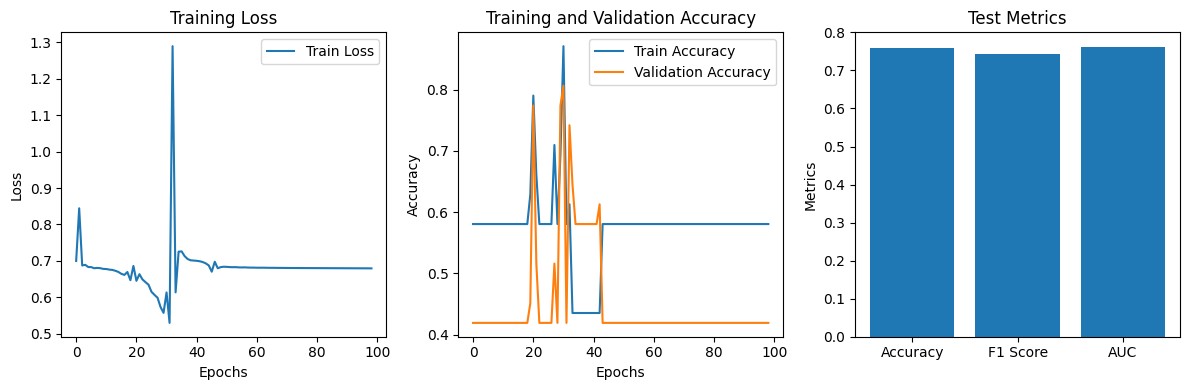

In [191]:
# Plotting

plt.figure(figsize=(12, 4))

  # Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

  # Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_eval_values, label='Train Accuracy')
plt.plot(val_eval_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

  # Assuming 'evaluate' function returns acc, f1, auc
acc, f1, auc = evaluate(best_model, test_loader)

  # Plot F1 Score and AUC
plt.subplot(1, 3, 3)
plt.bar(['Accuracy', 'F1 Score', 'AUC'], [acc, f1, auc])
plt.ylabel('Metrics')
plt.title('Test Metrics')

plt.tight_layout()
plt.show()